In [1]:
import catalyst
from catalyst import qjit

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize, OptimizeResult

import jax.numpy as jnp

In [19]:
## Layers and wires for circuits

symbols = ["Li", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

# Building the molecular hamiltonian for LiH
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    method="pyscf",
)

LAYERS = 1
WIRES = qubits

## https://docs.pennylane.ai/projects/catalyst/en/latest/code/api/catalyst.grad.html - ["fd", "ps", "adj"]
GRADIENT_METHOD= "fd"

TRAINING_ENERGIES= {"gradient_descent":{"energies":[], "trained_meta_vars":[]},
                    "spsa":{"energies":[], "trained_meta_vars":[]},
                    "adam":{"energies":[], "trained_meta_vars":[]},
                   }

# Encoder: 
# Linear -> 1
# Gaussian -> 2

ENCODER_MULTIPLIER_DICT = {1:2,
                      2:4}

ENCODER = 1

shared_dev = qml.device("lightning.qubit", wires=WIRES)

symbols = ["Li", "H"]

train_points = [1.0,2.0]

test_points = np.arange(0.6,6,0.2)


In [3]:
def linear_encoding(param_array, r):
    """1-D array with alphas and betas. len(param_array) = 2 * len(weights) 

    Args:
        param_array (float): alphas and betas for lineasr encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """
    return param_array[::2]*r + param_array[1::2]

In [4]:
def gaussian_encoding(param_array, r):
    """1-D array with alphas, betas, gammas and deltas. len(param_array) = 4 * len(weights) 

    Args:
        param_array (float): , betas, gammas and deltas for gaussian encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """

    exp_arg = param_array[1::4]*[i-r for i in param_array[2::4]]

    return param_array[::4]*np.exp(exp_arg) + param_array[3::4]

In [5]:
## Get shapes

## For linear is 2
## For Gaussian is 4
ENCODING_MULTIPLIER= ENCODER_MULTIPLIER_DICT[ENCODER]

if(ENCODER == 1):
    ENCODER_FUNC =linear_encoding
else:
    ENCODER_FUNC =gaussian_encoding

num_params = (WIRES + LAYERS*(WIRES-1)*2)*ENCODING_MULTIPLIER

shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=WIRES)
weights = np.random.random(num_params)

print("===== NUM OF PARAMETERS =====")
print(num_params)

===== NUM OF PARAMETERS =====
68


In [6]:
##Run for all points without training

@qml.qnode(shared_dev)
def catalyst_simplified_two_design(params, d):

    coordinates = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, d])

    # Building the molecular hamiltonian for LiH
    hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        method="pyscf",
    )    

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=qubits)

    init_weights, weights = np.reshape(params[:qubits],shapes[0]), np.reshape(params[qubits:],shapes[1])

    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(qubits))

    return qml.expval(
        qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
    )  

In [7]:
from jax.core import ShapedArray

@qjit
def energy_simplified_two_design(params: ShapedArray(shape=(num_params,), dtype=jnp.float64)):

    energies = []   

    for r in train_points:
   
        def catalyst_simplified_two_design(params):
        
            symbols = ["Li", "H"]
            coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])     
            
            # Building the molecular hamiltonian for LiH
            hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
                symbols,
                coordinates,
                method="pyscf",
            )
            
            print(coordinates)           
            
            shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=qubits)   

            weights_encoded =  ENCODER_FUNC(params, r)       

            init_weights, weights = np.reshape(weights_encoded[:qubits],shapes[0]), np.reshape(weights_encoded[qubits:],shapes[1])

            qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(qubits))

            return qml.expval(
                qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
            )  
                
        circuit = qml.QNode(catalyst_simplified_two_design, shared_dev)
        
        energies.append(circuit(params))
        
    join_energy = jnp.sum(jnp.array(energies))


    
    return join_energy/len(train_points) 

[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 2.]


In [8]:
from jax.core import ShapedArray

@qjit
def gradient_simplified_two_design(params: ShapedArray(shape=(num_params,), dtype=jnp.float64)):

    gradients = []

    for r in train_points:
   
        def catalyst_simplified_two_design(params):
        
            symbols = ["Li", "H"]
            coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])     
            
            # Building the molecular hamiltonian for LiH
            hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
                symbols,
                coordinates,
                method="pyscf",
            )
            
            print(coordinates)           
            
            shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=qubits)   

            weights_encoded =  ENCODER_FUNC(params, r)       

            init_weights, weights = np.reshape(weights_encoded[:qubits],shapes[0]), np.reshape(weights_encoded[qubits:],shapes[1])

            qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(qubits))

            return qml.expval(
                qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
            )  
                
        circuit = qml.QNode(catalyst_simplified_two_design, shared_dev)
        
        gradients.append(catalyst.grad(circuit, method = GRADIENT_METHOD )(params))
        
    all_gradients = jnp.array(gradients)
    joined_gradients = jnp.sum(jnp.array([all_gradients[i][0] for i in range(len(all_gradients))]), axis=0)

    
    return joined_gradients/len(train_points)

[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 2.]


In [9]:
energy_simplified_two_design(weights)


Array(-2.9886861, dtype=float64)

In [10]:
gradient_simplified_two_design(weights)

Array([ 1.28980804,  0.84935679,  1.12274533,  0.73245245,  0.20476052,
        0.19436212, -0.04077468, -0.05464212, -0.01369214, -0.02326446,
        0.02325288,  0.01910169, -0.06895789, -0.03736012, -0.04061142,
        0.0059292 ,  0.21279037,  0.20726332, -0.13015644, -0.10951409,
       -0.54316378, -0.35786511,  0.10507614,  0.10179384,  0.78715503,
        0.46223111, -0.39042057, -0.28196182,  0.04691892,  0.08599187,
       -0.10248455, -0.071076  ,  0.03608761,  0.02834836,  0.0486075 ,
        0.04602857,  0.2271395 ,  0.17342104,  0.01245167,  0.04404368,
       -0.03978235,  0.01127642, -0.15598292, -0.11577763, -0.10620061,
       -0.04049064,  0.16575623,  0.16274768, -0.7934626 , -0.44171208,
       -0.01433071,  0.00749495,  0.0071756 ,  0.00282604, -0.01905207,
       -0.01146463,  0.08887739,  0.05172502,  0.04600852,  0.02056351,
       -0.13686497, -0.10882053, -0.01355905, -0.04057454,  0.1713711 ,
        0.11044363, -0.24471542, -0.13656805], dtype=float64)

In [22]:
def gradient_descent(fun,x0, stepsize=0.1, tol=1e-4,maxiter=100, **options):

    new_params = jnp.array(x0)
    ref_energy = energy_simplified_two_design(new_params)
    
    energy_evolution = [ref_energy]    

    niter = 0

    for i in range(maxiter):
        niter +=1
        grad = gradient_simplified_two_design(new_params)

        new_params -= grad*stepsize

        new_energy = energy_simplified_two_design(new_params)
        
        energy_evolution.append(new_energy)

        if(np.abs(new_energy-ref_energy) < tol):
            break
        else:
            ref_energy = new_energy
            
    TRAINING_ENERGIES["gradient_descent"]["energies"].append(energy_evolution)
    TRAINING_ENERGIES["gradient_descent"]["trained_meta_vars"].append(new_params)
    
    print("Finished Gradient Descent training")

    return OptimizeResult(x=new_params, nit=niter)


In [23]:
def spsa_optimizer(fun, x0, maxiter=100,alpha=0.602,gamma=0.101, c=0.2, A=None, a=None, tol=1e-4, **options):
    new_params = jnp.array(x0)
    ref_energy = energy_simplified_two_design(new_params)
    
    energy_evolution = [ref_energy]       

    if not A:
        A = maxiter * 0.1

    if not a:
        a = 0.05 * (A + 1) ** alpha        

    niter = 0

    for i in range(maxiter):
        niter +=1

        ak=a/np.power(i+1+A,alpha)
        ck=c/np.power(i+1,gamma)

        delta = np.random.choice([-1, 1], size=x0.shape)

        thetaplus=new_params+ck*delta
        thetaminus=new_params-ck*delta
        yplus=energy_simplified_two_design(thetaplus)
        yminus=energy_simplified_two_design(thetaminus)  

        grad = jnp.array([(yplus - yminus) / (2 * ck * di) for di in delta]  )

        new_params -= ak*grad

        new_energy = energy_simplified_two_design(new_params)
        
        energy_evolution.append(new_energy)        

        if(np.abs(new_energy-ref_energy) < tol):
            break
        else:
            ref_energy = new_energy
            
    TRAINING_ENERGIES["spsa"]["energies"].append(energy_evolution)
    TRAINING_ENERGIES["spsa"]["trained_meta_vars"].append(new_params)  
    
    print("Finished SPSA training")
    

    return OptimizeResult(x=new_params, nit=niter)    

In [24]:
def adam(fun, x0, maxiter=100,stepsize=0.01, beta1=0.9, beta2=0.99, tol=1e-4,eps=1e-08, **options):
    new_params = jnp.array(x0)
    ref_energy = energy_simplified_two_design(new_params)
    
    energy_evolution = [ref_energy] 
      
    m = jnp.zeros_like(x0)
    v = jnp.zeros_like(x0)

    niter = 0

    for i in range(maxiter):
        niter +=1

        grad = gradient_simplified_two_design(new_params)

        m = beta1*m + (1-beta1)*grad
        v = beta2*v + (1-beta2)*jnp.square(grad)

        mhat = m/(1-beta1**(i+1))

        vhat = v/(1-beta2**(i+1))

        step = mhat/(jnp.array([np.sqrt(vhat_i) + eps for vhat_i in vhat]) )


        new_params -= stepsize*step

        new_energy = energy_simplified_two_design(new_params)
        
        energy_evolution.append(new_energy)         

        print("Step: ",i, " Energy: ", new_energy)

        if(np.abs(new_energy-ref_energy) < tol):
            break
        else:
            ref_energy = new_energy
            
    TRAINING_ENERGIES["adam"]["energies"].append(energy_evolution)
    TRAINING_ENERGIES["adam"]["trained_meta_vars"].append(new_params)  
    
    print("Finished ADAM training")
    

    return OptimizeResult(x=new_params, nit=niter)    

In [14]:
res_gradient = minimize(energy_simplified_two_design, weights, method = gradient_descent, tol=1e-6, maxiter= 200)
res_spsa = minimize(energy_simplified_two_design, weights, method = spsa_optimizer, tol=1e-6, maxiter= 200)
res_adam = minimize(energy_simplified_two_design, weights, method = adam, tol=1e-6, maxiter= 200)

Step:  0  Energy:  -3.116864982380798
Step:  1  Energy:  -3.248950654679202
Step:  2  Energy:  -3.3842897705437007
Step:  3  Energy:  -3.522070945556864
Step:  4  Energy:  -3.661466860035907
Step:  5  Energy:  -3.801730369987821
Step:  6  Energy:  -3.942227554820625
Step:  7  Energy:  -4.082400526624988
Step:  8  Energy:  -4.221694798377721
Step:  9  Energy:  -4.359494106059055
Step:  10  Energy:  -4.495100385378738
Step:  11  Energy:  -4.627755306461589
Step:  12  Energy:  -4.756679134948075
Step:  13  Energy:  -4.881110358430222
Step:  14  Energy:  -5.0003416219774595
Step:  15  Energy:  -5.113752491098786
Step:  16  Energy:  -5.220839329121934
Step:  17  Energy:  -5.321240897355478
Step:  18  Energy:  -5.4147571153784035
Step:  19  Energy:  -5.5013583082156075
Step:  20  Energy:  -5.581183225805919
Step:  21  Energy:  -5.654525815888833
Step:  22  Energy:  -5.72181248519642
Step:  23  Energy:  -5.783572722667726
Step:  24  Energy:  -5.840406074145381
Step:  25  Energy:  -5.892948163

In [17]:
trained_energies = []

for d in test_points:
    print(d)
    encoded_params = linear_encoding(res.x, d)
    energy= catalyst_simplified_two_design(encoded_params,d)
    trained_energies.append(energy)

0.6


/opt/conda/envs/python39/lib/python3.9/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


0.8
1.0
1.2000000000000002
1.4000000000000004
1.6000000000000005
1.8000000000000003
2.0000000000000004
2.2000000000000006
2.400000000000001
2.600000000000001
2.8000000000000007
3.000000000000001
3.200000000000001
3.400000000000001
3.600000000000001
3.800000000000001
4.000000000000001
4.200000000000001
4.400000000000001
4.600000000000001
4.800000000000001
5.000000000000001
5.200000000000001
5.400000000000001
5.600000000000001
5.800000000000002


<function matplotlib.pyplot.show(close=None, block=None)>

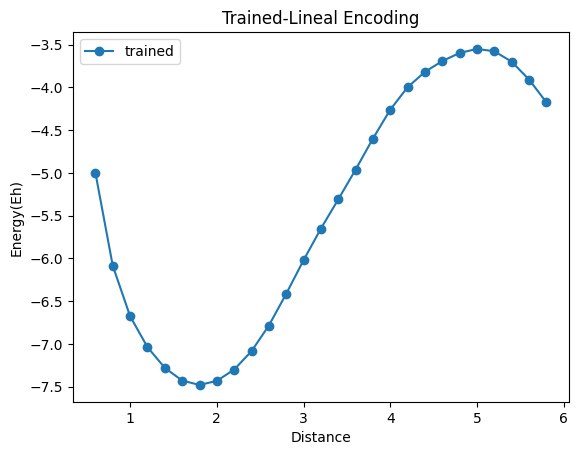

In [18]:
plt.plot(test_points, trained_energies, label="trained", marker='o')
plt.legend()
plt.title('Trained-Lineal Encoding')
plt.xlabel('Distance')
plt.ylabel('Energy(Eh)')
plt.show